In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pickle, math, datetime
from pprint import pformat
from graphviz import Digraph
from itertools import combinations, permutations
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix
from scipy.stats import entropy

import hmms
import os
import math

In [2]:
# Configuration parameters
K = 3
rejection_KL_thresh = 0.018
N_nodes = 81
random_state = 2
# rejection_negative_bias = 2
# pbl_negative_bias = 0
# pbr_negative_bias = 2
# rotl_negative_bias = 4
# rotr_negative_bias = 3
# pc_negative_bias = 0
rejection_negative_bias = 0
pbl_negative_bias = 0
pbr_negative_bias = 0
rotl_negative_bias = 0
rotr_negative_bias = 0
pcl_negative_bias = 0
pcr_negative_bias = 0

rejections_trained = False
# baum_welch = True
# bw_epochs = 10

# Observation matrix params
prob_emission_equals_hidden = 0.95

prob_emission_not_equals_hidden = 1 - prob_emission_equals_hidden

#Trans prob matrix params
trans_prob_factor = 100
rejection_trans_prob_factor = 1

#Init prob matrix params
init_prob_factor = 100
rejection_init_prob_factor = 1

classes = ["PBL", "PBR", "ROTL", "ROTR", "PCL", "PCR"]

## Load training QTC_C sequences (experimenter interacting in lab)

In [3]:
rotl_lab_seqs = []
rotr_lab_seqs = []
pb_l_lab_seqs = []
pb_r_lab_seqs = []
pcl_lab_seqs = []
pcr_lab_seqs = []
u_lab_seqs = []
u_lab_seqs_no_train = []

with open("controlled_lab_qtc_seqs.pickle", "rb") as f:
    lab_seqs = pickle.load(f)
lab_seqs

{'ot_hotr_12': ['-++0',
  '-0+0',
  '-++-',
  '-0+0',
  '-++-',
  '00+0',
  '-++-',
  '-0+0',
  '-++-',
  '-0+0',
  '-++-',
  '-0+0',
  '-++-',
  '00+0',
  '-++-',
  '-0+-',
  '00+0',
  '-++-',
  '0++-',
  '-0+-',
  '+0+0',
  '0++-',
  '00+-',
  '-0+-',
  '+0+-',
  '-0+-',
  '+0+0',
  '+-+-',
  '+0+0',
  '-0+-',
  '+0+0',
  '0-+-',
  '+-+-',
  '+0+-',
  '+-+-',
  '+0+-',
  '+-+-',
  '+0+0',
  '+-+-',
  '+0+0',
  '+-+-',
  '+0+0',
  '+-+-',
  '+0+0',
  '+-+-',
  '+0+0',
  '+-+-',
  '+0+0',
  '+0-0',
  '+0+0',
  '+-+-',
  '+0+0',
  '+-+-',
  '+-+0',
  '+-+-',
  '0-+-',
  '+-+0',
  '+0+0',
  '+-+-',
  '+-+0',
  '--+-',
  '+-+-'],
 'u_h_pb_l_robot_stationary_8': ['-0+0',
  '-0-0',
  '-0+0',
  '00+0',
  '+0+0',
  '-0+0',
  '+0+0',
  '-0+0',
  '+0+0'],
 'ot_hotl_6': ['-+-0',
  '-0-0',
  '-+-+',
  '-+-0',
  '-0-0',
  '-+-+',
  '-0-0',
  '-+-+',
  '-0-0',
  '-+-+',
  '-0-0',
  '+0-0',
  '-+-+',
  '0+-+',
  '00-+',
  '+0-+',
  '+0-0',
  '++-+',
  '+0-+',
  '+0-0',
  '+--+',
  '+0-+',
  '+0-0',


In [4]:
for key in lab_seqs.keys():
    if key.split("_")[0] == "u":
        print(key)

u_h_pb_l_robot_stationary_8
u_r_meets_stationary_h_13
u_r_meets_stationary_h_9
u_h_pb_r_robot_stationary_6
u_h_pb_r_robot_stationary_7
u_h_pb_l_robot_stationary_6
u_h_pb_l_robot_stationary_7
u_r_meets_stationary_h_12
u_h_and_r_stationary_12
u_h_pb_r_robot_stationary_8
u_h_meets_stationary_r_12
u_h_meets_stationary_r_13
u_h_meets_stationary_r_10
u_h_meets_stationary_r_11
u_h_meets_stationary_r_14
u_h_meets_stationary_r_15
u_h_and_r_stationary_9
u_h_meets_stationary_r_6
u_h_meets_stationary_r_7
u_h_pb_l_robot_stationary_12
u_h_and_r_stationary_8
u_r_meets_stationary_h_11
u_h_pb_l_robot_stationary_15
u_h_pb_l_robot_stationary_13
u_h_pb_r_robot_stationary_9
u_h_and_r_stationary_6
u_h_pb_r_robot_stationary_14
u_h_pb_r_robot_stationary_15
u_h_pb_r_robot_stationary_10
u_h_pb_r_robot_stationary_11
u_h_pb_r_robot_stationary_12
u_h_pb_r_robot_stationary_13
u_h_and_r_stationary_11
u_h_and_r_stationary_10
u_h_and_r_stationary_13
u_h_and_r_stationary_15
u_h_and_r_stationary_14
u_r_meets_stationary_

In [5]:
for key in lab_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[1] == "rotl":
        rotl_lab_seqs.append(lab_seqs[key])
    elif key.split("_")[1] == "rotr":
        rotr_lab_seqs.append(lab_seqs[key])
    elif class_code == "pb":
        if key.split("_")[1] == "l":
            pb_l_lab_seqs.append(lab_seqs[key])
        elif key.split("_")[1] == "r":
            pb_r_lab_seqs.append(lab_seqs[key])
    elif "pc_l" in key:
        pcl_lab_seqs.append(lab_seqs[key])
    elif "pc_r" in key:
        pcr_lab_seqs.append(lab_seqs[key])
    elif "u_r_meets_stationary_h" in key:
        u_lab_seqs.append(lab_seqs[key])

In [6]:
print(len(rotl_lab_seqs))
print(len(rotr_lab_seqs))
print(len(pb_l_lab_seqs))
print(len(pb_r_lab_seqs))
print(len(pcl_lab_seqs))
print(len(pcr_lab_seqs))
print(len(u_lab_seqs))

32
31
30
30
30
30
10


## Load test QTC_C sequences (participants interacting in lab study)

In [7]:
rotl_study_seqs = []
rotr_study_seqs = []
pb_l_study_seqs = []
pb_r_study_seqs = []
pcl_study_seqs = []
pcr_study_seqs = []
u_study_seqs = []
u_study_seqs_no_train = []

with open("study_qtc_seqs.pickle", "rb") as f:
    study_seqs = pickle.load(f)
study_seqs

{'pcr_4': ['+-+-',
  '-0+0',
  '0-+-',
  '-0+-',
  '--+-',
  '-0+0',
  '0-+-',
  '-0+-',
  '--+-',
  '-0+0',
  '--+-',
  '0-+-',
  '--+-',
  '-0+0',
  '0-+-',
  '--+-',
  '0-+-',
  '-0+0',
  '+-+-',
  '--+-',
  '-0+0',
  '00+-',
  '-0+0',
  '--+-',
  '0-+-',
  '-0+0',
  '00+0',
  '-0+0',
  '+-+-',
  '00+-',
  '--+-',
  '0-+-',
  '--+-',
  '-0+0',
  '+-+-',
  '--+-',
  '-0+0',
  '+-+-',
  '0-+0',
  '0-+-',
  '--+0',
  '0-+-',
  '-0+0',
  '+-+-',
  '0-+-',
  '-0+0',
  '+-+-',
  '+-+0',
  '0-+0',
  '-0+0',
  '+-+-',
  '0-+-',
  '0-+0',
  '00+0',
  '+-+-',
  '0-+0',
  '--+0',
  '00+0',
  '+-+-',
  '0-+0',
  '+-+0',
  '-0+0',
  '00+0',
  '+-+-',
  '+-+0',
  '00+0',
  '+-+0',
  '---0',
  '00+0',
  '+-+0',
  '---0',
  '00+0',
  '+-+0',
  '---0',
  '0-+0',
  '00+0',
  '-0-0',
  '+-+0',
  '---0',
  '00+0',
  '--+0',
  '+-+0',
  '0-+0',
  '-0+0',
  '00+0',
  '+-+0',
  '-0+0',
  '00+0',
  '+-00',
  '+-+0',
  '00+0',
  '+-+0',
  '00+0',
  '+-+0',
  '0-00',
  '00+0',
  '+-++',
  '+-+0',
  '00+0',
 

In [8]:
len(study_seqs)

75

In [9]:
for key in study_seqs.keys():
    class_code = key.split("_")[0]
    
    if key.split("_")[0] == "rotl":
        rotl_study_seqs.append(study_seqs[key])
    elif key.split("_")[0] == "rotr":
        rotr_study_seqs.append(study_seqs[key])
    elif "pb" in class_code:
        if "l" in class_code:
            pb_l_study_seqs.append(study_seqs[key])
        else:
            pb_r_study_seqs.append(study_seqs[key])
    elif "pc" in class_code:
        if "l" in class_code:
            pcl_study_seqs.append(study_seqs[key])
        else:
            pcr_study_seqs.append(study_seqs[key])
    else:
        u_study_seqs.append(study_seqs[key])
        
print(len(rotl_study_seqs))
print(len(rotr_study_seqs))
print(len(pb_l_study_seqs))
print(len(pb_r_study_seqs))
print(len(pcl_study_seqs))
print(len(pcr_study_seqs))
print(len(u_study_seqs))

11
10
11
11
11
10
11


In [10]:
# Create list of QTC_C states so that indices can be used as integer state IDs compatible with HMM library
QTC_symbols = []
for i in range(0,4):
    QTC_symbols.append("-")
    QTC_symbols.append("0")
    QTC_symbols.append("+")
print("QTC symbols:", QTC_symbols[:3])
QTC_C_states = list(combinations(QTC_symbols, 4))
QTC_C_states = [state[0] + state[1] + state[2] + state[3] for state in QTC_C_states]
QTC_C_states = list(np.unique(QTC_C_states))
print("QTC_C states:\n", QTC_C_states)
print(len(QTC_C_states), "states total")

QTC symbols: ['-', '0', '+']
QTC_C states:
 ['++++', '+++-', '+++0', '++-+', '++--', '++-0', '++0+', '++0-', '++00', '+-++', '+-+-', '+-+0', '+--+', '+---', '+--0', '+-0+', '+-0-', '+-00', '+0++', '+0+-', '+0+0', '+0-+', '+0--', '+0-0', '+00+', '+00-', '+000', '-+++', '-++-', '-++0', '-+-+', '-+--', '-+-0', '-+0+', '-+0-', '-+00', '--++', '--+-', '--+0', '---+', '----', '---0', '--0+', '--0-', '--00', '-0++', '-0+-', '-0+0', '-0-+', '-0--', '-0-0', '-00+', '-00-', '-000', '0+++', '0++-', '0++0', '0+-+', '0+--', '0+-0', '0+0+', '0+0-', '0+00', '0-++', '0-+-', '0-+0', '0--+', '0---', '0--0', '0-0+', '0-0-', '0-00', '00++', '00+-', '00+0', '00-+', '00--', '00-0', '000+', '000-', '0000']
81 states total


In [11]:
def QTC_C_to_num(QTC_C):
    return QTC_C_states.index(QTC_C)


def QTC_C_seq_to_num_seq(QTC_C_seq):
    num_seq = []
    for QTC_C in QTC_C_seq:
        num_seq.append(QTC_C_to_num(QTC_C))

    return num_seq


def num_to_QTC_C(num):
    return QTC_C_states[num]


def num_seq_to_QTC_C_seq(num_seq):
    QTC_C_seq = []
    for num in num_seq:
        QTC_C_seq.append(num_to_QTC_C(num))

    return QTC_C_seq


print(QTC_C_to_num("++--"))
print(num_to_QTC_C(8))
print(num_seq_to_QTC_C_seq([0, 1, 2, 3]))
print(QTC_C_seq_to_num_seq(num_seq_to_QTC_C_seq([0, 1, 2, 3])))

4
++00
['++++', '+++-', '+++0', '++-+']
[0, 1, 2, 3]


In [12]:
# Defining a uniform transition matrix of N_nodes states
uniform_trans_mat = np.zeros((N_nodes, N_nodes))
uniform_trans_mat = np.array([[1/N_nodes for trans in row] for row in uniform_trans_mat])
print("\n", uniform_trans_mat)
row_sums = []
for row in uniform_trans_mat:
    row_sums.append(np.sum(row))
print(np.mean(row_sums))


 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 ...
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]
 [0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.01234568]]
1.0


In [13]:
def draw_transition_matrix(trans_matrix, filename, min_trans_prob):
    # draw its transition matrix
    dot = Digraph(comment='HMM model')
    col, row = trans_matrix.shape
    for i in range(0, col):
        for j in range(0, row):
#             print(i, j, trans_matrix[i, j])
            if trans_matrix[i, j] >= min_trans_prob:
#                 print(i, j, "is a high probability transition")
                dot.edge(num_to_QTC_C(i), num_to_QTC_C(j), label='{:2.2f}'.format(trans_matrix[i, j]))

    dot.render(filename, view=True)

## Creating pass-by left HMM

In [14]:
pass_by_l_seqs = pb_l_lab_seqs

In [15]:
pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
print(pass_by_l_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

[[50, 13, 40, 50, 40, 41, 50, 40, 50, 13, 40, 50, 40, 50, 13, 40, 13, 50, 40, 37, 50, 40, 41, 50, 40, 10, 40, 53, 50, 10, 40, 50, 67, 40, 50, 40, 50, 40, 49, 50, 70, 50, 67, 49, 40, 76, 73, 76, 77, 79, 76, 22, 55, 49, 22, 58, 23, 4, 22, 23, 4, 23, 4, 23, 4, 23, 4, 23, 61, 4, 23, 4, 23, 4, 23, 4, 23, 55, 4, 23, 7, 4], [26, 47, 30, 27, 3, 0], [38, 44, 53, 47, 36, 44, 47, 15, 38, 36, 44, 47, 38, 44, 47, 69, 38, 47, 36, 38, 47, 69, 36, 38, 47, 63, 36, 47, 36, 38, 36, 47, 15, 38, 36, 47, 36, 38, 69, 38, 42, 36, 47, 36, 47, 36, 47, 36, 47, 36, 47, 36, 47, 36, 12, 47, 12, 39, 36, 47, 42, 36, 47, 36, 42, 47, 23, 12, 39, 36, 20, 12, 47, 42, 12, 47, 39, 63, 47, 66, 72, 47, 74, 75, 72, 45, 72, 20, 30, 0, 47, 30, 0, 20, 30, 0, 20, 33, 0, 20, 0, 20, 0, 20, 2, 27, 20, 2, 20, 0, 2, 20, 29, 56, 2, 20], [47, 36, 65, 47, 15, 38, 36, 47, 36, 47, 12, 38, 47, 15, 36, 47, 15, 38, 36, 47, 36, 47, 36, 47, 36, 38, 47, 36, 38, 36, 47, 36, 53, 47, 9, 36, 39, 36, 39, 36, 47, 15, 36, 47, 12, 36, 12, 47, 36, 47, 36

[['-0-0',
  '+---',
  '----',
  '-0-0',
  '----',
  '---0',
  '-0-0',
  '----',
  '-0-0',
  '+---',
  '----',
  '-0-0',
  '----',
  '-0-0',
  '+---',
  '----',
  '+---',
  '-0-0',
  '----',
  '--+-',
  '-0-0',
  '----',
  '---0',
  '-0-0',
  '----',
  '+-+-',
  '----',
  '-000',
  '-0-0',
  '+-+-',
  '----',
  '-0-0',
  '0---',
  '----',
  '-0-0',
  '----',
  '-0-0',
  '----',
  '-0--',
  '-0-0',
  '0-0-',
  '-0-0',
  '0---',
  '-0--',
  '----',
  '00--',
  '00+-',
  '00--',
  '00-0',
  '000-',
  '00--',
  '+0--',
  '0++-',
  '-0--',
  '+0--',
  '0+--',
  '+0-0',
  '++--',
  '+0--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '0+0-',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '0++-',
  '++--',
  '+0-0',
  '++0-',
  '++--'],
 ['+000', '-0+0', '-+-+', '-+++', '++-+', '++++'],
 ['--+0',
  '--00',
  '-000',
  '-0+0',
  '--++',
  '--00',
  '-0+0',
  '+-0+',
  '--+0',
  '--++',
  '--00',
  '-0+0',
  '--+0'

In [16]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_l_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
0
1
2
3
4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
4

In [17]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_l_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pblHMM = hmms.DtHMM(A, B, Pi)

# Check pblHMM params
A, B, Pi = pblHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[1.41222991e-04 1.41222991e-04 2.68464906e-01 ... 1.41222991e-04
  1.41222991e-04 1.41222991e-04]
 [3.55871886e-03 3.55871886e-03 3.55871886e-03 ... 3.55871886e-03
  3.55871886e-03 3.55871886e-03]
 [1.29090441e-01 2.57665550e-04 2.57665550e-04 ... 2.57665550e-04
  2.57665550e-04 2.57665550e-04]
 ...
 [5.52486188e-03 5.52486188e-03 5.52486188e-03 ... 5.52486188e-03
  5.52486188e-03 5.52486188e-03]
 [1.72117040e-03 1.72117040e-03 1.72117040e-03 ... 1.72117040e-03
  1.72117040e-03 1.72117040e-03]
 [5.52486188e-03 5.52486188e-03 5.52486188e-03 ... 5.52486188e-03
  5.52486188e-03 5.52486188e-03]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.1

In [18]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Left_Lab_Egs_Transitions", 0.013)

Pass-by left HMM:


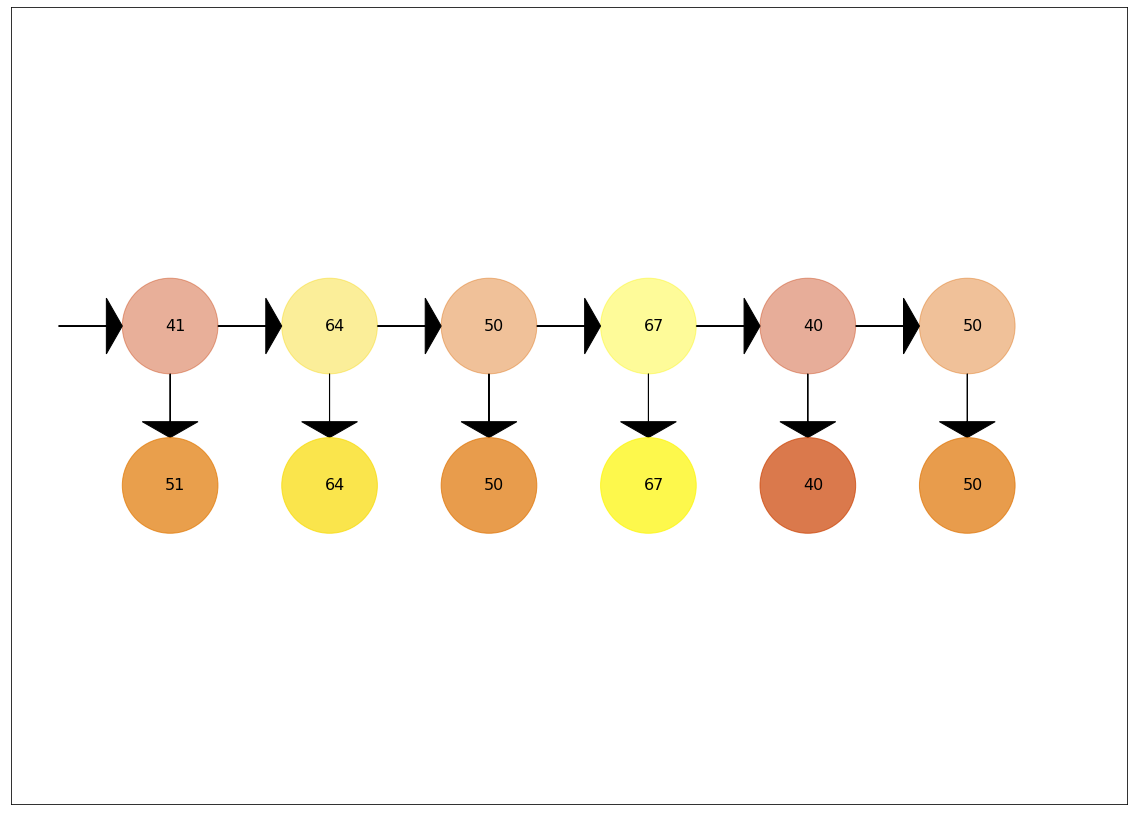

['---0', '0-+-', '-0-0', '0---', '----', '-0-0']


In [19]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pblHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating pass-by right HMM

In [20]:
pass_by_r_seqs = pb_r_lab_seqs

In [21]:
pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
print(pass_by_r_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

[[40, 41, 40, 50, 40, 41, 50, 40, 50, 40, 47, 40, 50, 37, 40, 74, 50, 40, 67, 40, 50, 16, 40, 50, 40, 13, 50, 13, 40, 49, 50, 13, 76, 77, 49, 77, 22, 49, 23, 4, 22, 23, 4, 23, 4, 23, 4, 23, 4, 23, 4, 23, 4], [50, 40, 41, 50, 13, 40, 41, 40, 50, 40, 50, 40, 50, 13, 40, 43, 40, 50, 10, 40, 13, 50, 40, 50, 67, 40, 50, 40, 49, 50, 67, 49, 22, 77, 76, 49, 76, 23, 50, 61, 22, 23, 31, 22, 4, 22, 23, 4, 22, 4, 23, 4, 23, 4, 23, 4, 23, 4, 23, 4, 23, 61, 4, 5, 23, 4, 23, 4], [44, 38, 47, 71, 38, 47, 71, 38, 47, 36, 38, 36, 38, 47, 63, 38, 36, 38, 36, 38, 47, 36, 38, 47, 63, 38, 39, 38, 47, 39, 36, 39, 47, 63, 36, 42, 36, 47, 63, 36, 47, 63, 36, 39, 36, 47, 36, 47, 50, 36, 47, 39, 36, 45, 36, 47, 48, 45, 27, 54, 0, 27, 20, 33, 27, 0, 20, 27, 0, 2, 20, 27, 0, 2, 20, 27, 2, 20, 2, 20, 2, 20, 29, 2, 20, 28, 8, 2, 20, 28, 5, 2, 5, 20, 55, 1], [40, 50, 40, 50, 67, 40, 50, 40, 70, 40, 50, 40, 16, 40, 50, 10, 40, 50, 67, 40, 43, 40, 50, 40, 50, 40, 50, 40, 49, 50, 40, 76, 23, 58, 22, 23, 58, 23, 4, 23, 

[['----',
  '---0',
  '----',
  '-0-0',
  '----',
  '---0',
  '-0-0',
  '----',
  '-0-0',
  '----',
  '-0+0',
  '----',
  '-0-0',
  '--+-',
  '----',
  '00+0',
  '-0-0',
  '----',
  '0---',
  '----',
  '-0-0',
  '+-0-',
  '----',
  '-0-0',
  '----',
  '+---',
  '-0-0',
  '+---',
  '----',
  '-0--',
  '-0-0',
  '+---',
  '00--',
  '00-0',
  '-0--',
  '00-0',
  '+0--',
  '-0--',
  '+0-0',
  '++--',
  '+0--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--',
  '+0-0',
  '++--'],
 ['-0-0',
  '----',
  '---0',
  '-0-0',
  '+---',
  '----',
  '---0',
  '----',
  '-0-0',
  '----',
  '-0-0',
  '----',
  '-0-0',
  '+---',
  '----',
  '--0-',
  '----',
  '-0-0',
  '+-+-',
  '----',
  '+---',
  '-0-0',
  '----',
  '-0-0',
  '0---',
  '----',
  '-0-0',
  '----',
  '-0--',
  '-0-0',
  '0---',
  '-0--',
  '+0--',
  '00-0',
  '00--',
  '-0--',
  '00--',
  '+0-0',
  '-0-0',
  '0+0-',
  '+0--',
  '+0-0',
  '-+--',
  '+0--',
  '++--',
  '+0--',
  '+0-0',

In [22]:
# Create transition matrix from handwritten examples of pass-by QTC-B sequences
# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pass_by_r_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
0
1

In [23]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())

# Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in pass_by_r_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

# print(Pi)
# print(Pi.sum())

# Create HMM using the pass-by e.g. parameters
pbrHMM = hmms.DtHMM(A, B, Pi)

# Check pbrHMM params
A, B, Pi = pbrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

A:
 [[9.27557740e-05 9.27557740e-05 2.87635655e-01 ... 9.27557740e-05
  9.27557740e-05 9.27557740e-05]
 [3.47101701e-04 3.47101701e-04 3.47448802e-01 ... 3.47101701e-04
  3.47101701e-04 3.47101701e-04]
 [4.14700770e-02 2.49151560e-02 8.27746048e-05 ... 8.27746048e-05
  8.27746048e-05 8.27746048e-05]
 ...
 [3.55871886e-03 3.55871886e-03 3.55871886e-03 ... 3.55871886e-03
  3.55871886e-03 3.55871886e-03]
 [9.25069380e-04 9.25069380e-04 9.25069380e-04 ... 9.25069380e-04
  9.25069380e-04 9.25069380e-04]
 [1.01936799e-03 1.01936799e-03 1.01936799e-03 ... 1.01936799e-03
  1.01936799e-03 1.01936799e-03]]
1.0
B:
 [[9.50617284e-01 6.17283951e-04 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 9.50617284e-01 6.17283951e-04 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 [6.17283951e-04 6.17283951e-04 9.50617284e-01 ... 6.17283951e-04
  6.17283951e-04 6.17283951e-04]
 ...
 [6.17283951e-04 6.17283951e-04 6.17283951e-04 ... 9.50617284e-01
  6.17283951e-04 6.1

In [24]:
# draw_transition_matrix(A,"QTC_C_Pass-By-Right_Lab_Egs_Transitions", 0.013)

Pass-by right HMM:


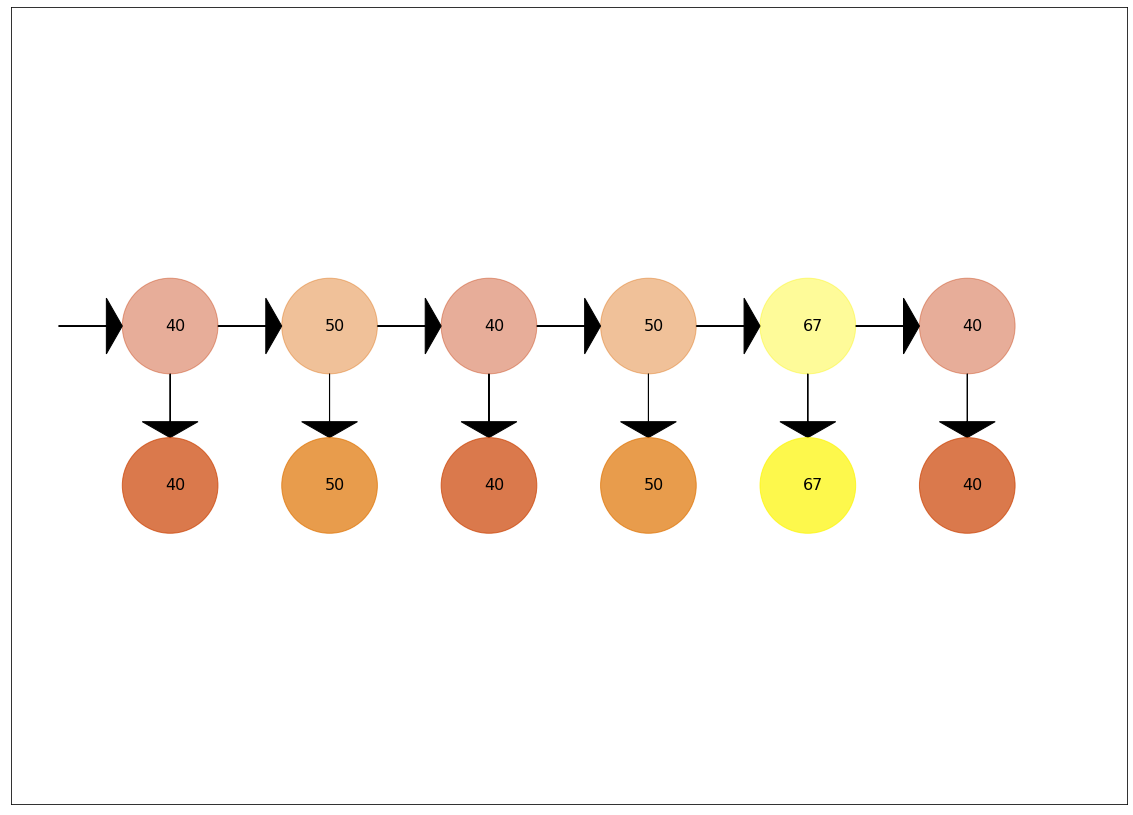

['----', '-0-0', '----', '-0-0', '0---', '----']


In [25]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pbrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Pass-by right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))


## Creating robot overtakes left HMM

In [26]:
rotl_seqs = rotl_lab_seqs

In [27]:
rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
print(rotl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

[[10, 80, 10, 16, 10, 13, 16, 50, 53, 10, 68, 80, 10, 16, 50, 10, 70, 50, 10, 53, 50, 10, 64, 37, 50, 10, 37, 10, 47, 10, 64, 47, 53, 10, 70, 64, 43, 53, 10, 64, 67, 10, 53, 64, 70, 77, 10, 50, 16, 53, 10, 13, 70, 53, 10, 70, 74, 53, 10, 53, 80, 10, 43, 53, 80, 10, 70, 10, 53, 10, 16, 70, 80, 23, 10, 64, 13, 80, 10, 23, 80, 10, 23, 10, 70, 10, 77, 50, 77, 10, 67, 10, 50, 10, 70, 10, 47, 50, 10, 80, 10, 80, 10, 70, 10, 70, 53, 64, 79, 50, 10, 80, 10, 64, 76, 50, 10, 67, 50, 10, 70, 50, 10, 70, 64, 79, 77, 50, 10, 64, 10, 64, 70, 64, 10, 80, 10, 64, 73, 80, 23, 10, 64, 77, 10, 64, 77, 10, 64, 77, 10, 37, 73, 64, 77, 37, 73, 46, 77, 10, 77, 64, 79, 73, 23, 64, 73, 19, 77, 73, 19, 77, 73, 19, 77, 46, 79, 25, 47, 77, 46, 80, 79, 80, 73, 46, 80, 79, 19, 80, 73, 79, 20, 80, 20, 80, 74], [11, 80, 50, 64, 10, 50, 80, 10, 71, 64, 13, 70, 80, 53, 10, 16, 44, 23, 10, 16, 13, 10, 50, 10, 70, 10, 53, 50, 10, 64, 10, 37, 10, 53, 10, 37, 10, 70, 10, 70, 50, 53, 77, 10, 43, 10, 23, 53, 10, 13, 53, 10, 

[['+-+-',
  '0000',
  '+-+-',
  '+-0-',
  '+-+-',
  '+---',
  '+-0-',
  '-0-0',
  '-000',
  '+-+-',
  '0--0',
  '0000',
  '+-+-',
  '+-0-',
  '-0-0',
  '+-+-',
  '0-0-',
  '-0-0',
  '+-+-',
  '-000',
  '-0-0',
  '+-+-',
  '0-+-',
  '--+-',
  '-0-0',
  '+-+-',
  '--+-',
  '+-+-',
  '-0+0',
  '+-+-',
  '0-+-',
  '-0+0',
  '-000',
  '+-+-',
  '0-0-',
  '0-+-',
  '--0-',
  '-000',
  '+-+-',
  '0-+-',
  '0---',
  '+-+-',
  '-000',
  '0-+-',
  '0-0-',
  '00-0',
  '+-+-',
  '-0-0',
  '+-0-',
  '-000',
  '+-+-',
  '+---',
  '0-0-',
  '-000',
  '+-+-',
  '0-0-',
  '00+0',
  '-000',
  '+-+-',
  '-000',
  '0000',
  '+-+-',
  '--0-',
  '-000',
  '0000',
  '+-+-',
  '0-0-',
  '+-+-',
  '-000',
  '+-+-',
  '+-0-',
  '0-0-',
  '0000',
  '+0-0',
  '+-+-',
  '0-+-',
  '+---',
  '0000',
  '+-+-',
  '+0-0',
  '0000',
  '+-+-',
  '+0-0',
  '+-+-',
  '0-0-',
  '+-+-',
  '00-0',
  '-0-0',
  '00-0',
  '+-+-',
  '0---',
  '+-+-',
  '-0-0',
  '+-+-',
  '0-0-',
  '+-+-',
  '-0+0',
  '-0-0',
  '+-+-',
  '0000',


In [28]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106

205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1.23456790e-02 1.23456790e-02 1.23456790e-02 ... 1.23456790e-02
  1.23456790e-02 1.23456790e-02]
 [1.72117040e-03 1.72117040e-03 1.72117040e-03 ... 1.72117040e-03
  1.72117040e-03 1.72117040e-03]
 [1.23456790e-02 1.23456790e-02 1.23456790e-02 ... 1.23456790e-02
  1.23456790e-02 1.23456790e-02]
 ...
 [1.23456790e-02 1.23456790e-02 1.23456790e-02 ... 1.23456790e-02
  1.23456790e-02 1.23456790e-02]
 [2.44015519e-05 2.46455675e-03 2.44015519e-05 ... 2.44015519e-05
  2.44015519e-05 1.17151851e-01]
 [1.38732814e-05 1.40120143e-03 1.38732814e-05 ... 1.38732814e-05
  3.88590613e-02 1.38732814e-05]]


In [29]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotlHMM = hmms.DtHMM(A, B, Pi)

# Check rotlHMM params
A, B, Pi = rotlHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.12221884 0.06126181
 0.00030479 0.00030479 0.00030479 0.00030479 0.09174032 0.24413289
 0.00030479 0.00030479 0.00030479 0.00030479 0.0307833  0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.0307833
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.0307833
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.0307833  0.00030479
 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.12221884 0.00030479 0.00030479 0.00030479 0.00030479
 0.00030479 0.00030479 0.21365437]
0.9999999999999999
A:
 [[1.23456790e-02 1.23456790e-02 1.23456790e-02 ... 1.23456790e-02
  1

In [30]:
A.min()

6.254651897348657e-06

In [31]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Left_Lab_Egs_Transitions", 0.0124)

Robot overtakes left HMM:


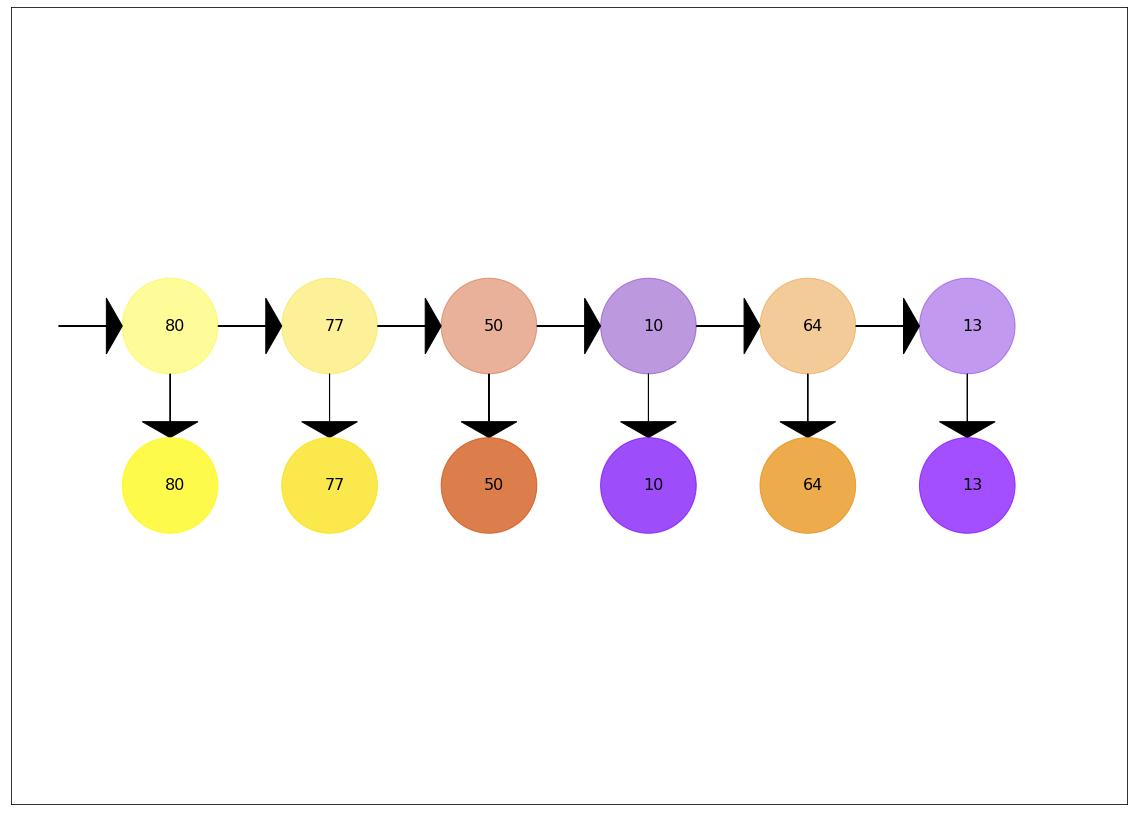

['0000', '00-0', '-0-0', '+-+-', '0-+-', '+---']


In [32]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotlHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating robot overtakes right HMM

In [33]:
rotr_seqs = rotr_lab_seqs

In [34]:
rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
print(rotr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

[[80, 12, 66, 12, 50, 12, 66, 12, 77, 12, 75, 12, 15, 66, 47, 12, 75, 12, 63, 66, 12, 47, 12, 66, 45, 12, 75, 39, 78, 80, 12, 39, 80, 53, 12, 66, 53, 12, 66, 53, 80, 12, 66, 12, 66, 74, 12, 66, 80, 66, 12, 36, 47, 12, 66, 39, 47, 39, 78, 45, 47, 12, 80, 66, 78, 74, 66, 80, 78, 74, 12, 51, 66, 74, 12, 21, 75, 66, 74, 12, 75, 45, 74, 66, 39, 74, 39, 75, 51, 78, 47, 66, 75, 78, 74, 75, 78, 45, 75, 18, 74, 48, 75, 72, 30, 75, 72, 74, 30, 48, 78, 30, 51, 78, 48, 74, 47, 30, 78, 48, 78, 30, 48, 47, 30, 78, 45, 30, 57, 51, 74, 30, 78, 30, 33, 75, 74, 30, 57, 74, 30, 74, 30, 33, 51, 74, 30, 80, 74, 30, 33, 21, 74, 30, 3, 74, 30, 23, 74, 30, 21, 30, 80, 30, 3, 30, 57, 80, 30, 57, 80, 53, 30, 60, 78, 80, 53, 30, 78, 74, 53, 80, 50], [80, 12, 75, 12, 20, 80, 12, 74, 12, 53, 80, 12, 50, 80, 12, 39, 12, 39, 80, 12, 51, 66, 80, 12, 42, 12, 80, 12, 72, 47, 74, 80, 12, 69, 75, 66, 80, 47, 12, 78, 66, 47, 80, 12, 66, 47, 74, 12, 66, 36, 12, 66, 42, 47, 12, 66, 47, 12, 66, 80, 12, 66, 75, 74, 12, 66, 80

[['0000',
  '+--+',
  '0--+',
  '+--+',
  '-0-0',
  '+--+',
  '0--+',
  '+--+',
  '00-0',
  '+--+',
  '00-+',
  '+--+',
  '+-0+',
  '0--+',
  '-0+0',
  '+--+',
  '00-+',
  '+--+',
  '0-++',
  '0--+',
  '+--+',
  '-0+0',
  '+--+',
  '0--+',
  '-0++',
  '+--+',
  '00-+',
  '---+',
  '000+',
  '0000',
  '+--+',
  '---+',
  '0000',
  '-000',
  '+--+',
  '0--+',
  '-000',
  '+--+',
  '0--+',
  '-000',
  '0000',
  '+--+',
  '0--+',
  '+--+',
  '0--+',
  '00+0',
  '+--+',
  '0--+',
  '0000',
  '0--+',
  '+--+',
  '--++',
  '-0+0',
  '+--+',
  '0--+',
  '---+',
  '-0+0',
  '---+',
  '000+',
  '-0++',
  '-0+0',
  '+--+',
  '0000',
  '0--+',
  '000+',
  '00+0',
  '0--+',
  '0000',
  '000+',
  '00+0',
  '+--+',
  '-00+',
  '0--+',
  '00+0',
  '+--+',
  '+0-+',
  '00-+',
  '0--+',
  '00+0',
  '+--+',
  '00-+',
  '-0++',
  '00+0',
  '0--+',
  '---+',
  '00+0',
  '---+',
  '00-+',
  '-00+',
  '000+',
  '-0+0',
  '0--+',
  '00-+',
  '000+',
  '00+0',
  '00-+',
  '000+',
  '-0++',
  '00-+',
  '+0++',


In [35]:
# Create transition matrix from handwritten examples of overtake QTC-B sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in rotr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120

36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
14

In [36]:
# creating observation matrix
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
# (We may make a stronger assumption here at some point)
Pi = (np.ones((1, N_nodes)))[0]
for seq in rotr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
rotrHMM = hmms.DtHMM(A, B, Pi)

# Check rotrHMM params
A, B, Pi = rotrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.03175102 0.00031437
 0.12606099 0.00031437 0.03175102 0.06318768 0.00031437 0.28324426
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.03175102 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437 0.00031437
 0.06318768 0.00031437 0.00031437 0.03175102 0.00031437 0.06318768
 0.00031437 0.00031437 0.00031437 0.06318768 0.00031437 0.00031437
 0.03175102 0.00031437 0.15749764]
1.0000000000000002
A:
 [[5.52486188e-03 5.52486188e-03 5.52486188e-03 ... 5.52486188e-03
 

In [37]:
A.min()

7.900079790805889e-06

In [38]:
# draw_transition_matrix(A, "QTC_C_Robot-Overtakes-Right_Lab_Egs_Transitions", 0.0124)

Robot overtakes right HMM:


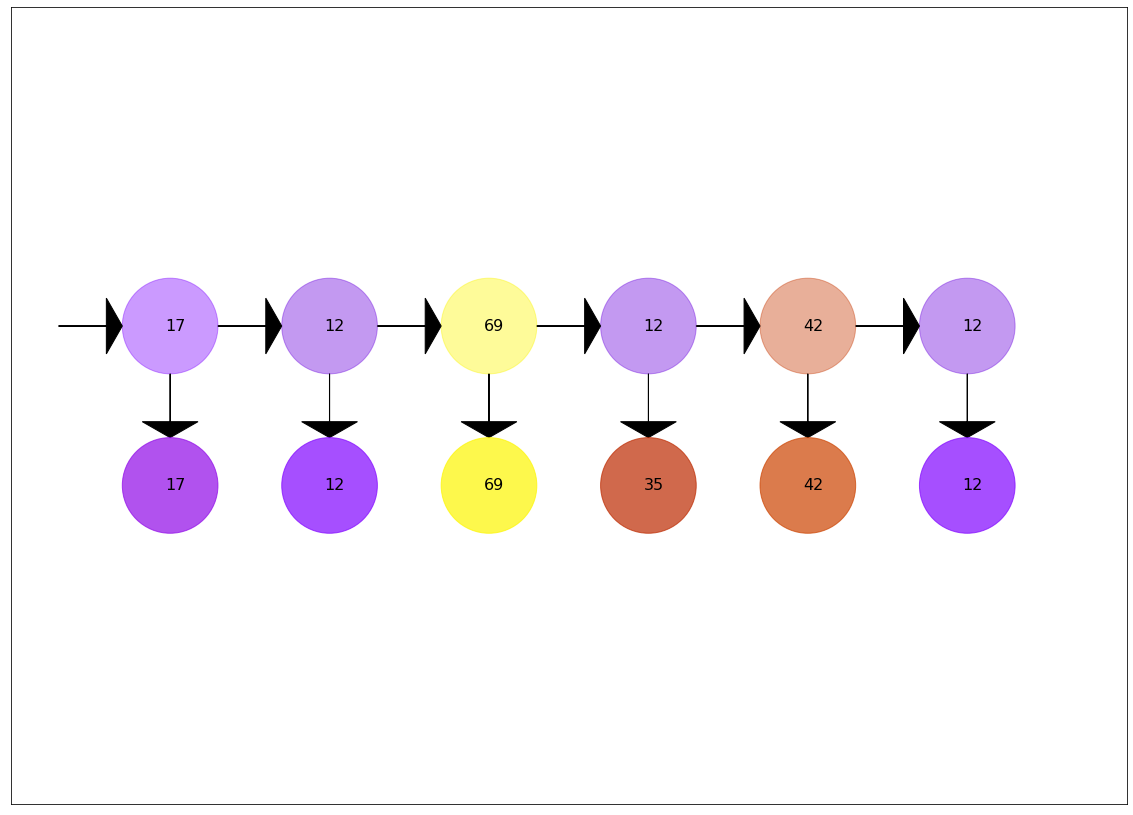

['+-00', '+--+', '0-0+', '+--+', '--0+', '+--+']


In [39]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = rotrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Robot overtakes right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating human crossing robot path from left HMM

In [40]:
pcl_seqs = pcl_lab_seqs

In [41]:
pcl_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcl_seqs]
print(pcl_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pcl_seqs]

[[66, 39, 50, 39, 41, 12, 39, 50, 12, 39, 50, 12, 68, 41, 50, 12, 41, 68, 50, 41, 68, 50, 14, 41, 50, 13, 68, 50, 13, 40, 50, 13, 40, 67, 23, 50, 77, 13, 77, 50, 13, 50, 23, 13, 23, 67, 13, 23, 13, 23, 13, 23, 13, 23, 13, 23, 13, 23, 13, 23, 13, 16, 13, 23, 13, 10, 13], [50, 39, 66, 39, 50, 39, 41, 50, 39, 71, 50, 12, 41, 14, 41, 50, 14, 50, 41, 68, 41, 50, 13, 41, 50, 40, 41, 67, 50, 13, 67, 41, 50, 13, 70, 40, 13, 41, 74, 50, 13, 40, 67, 50, 13, 77, 13, 77, 23, 13, 22, 23, 13, 23, 13, 23, 13, 23, 13, 23, 13, 22, 46, 13, 10, 13, 23, 10, 22, 13, 22, 13, 10, 22, 23, 10, 22, 23, 13, 22, 23, 10, 22, 23, 19, 22], [66, 39, 41, 50, 39, 66, 41, 50, 66, 39, 50, 12, 41, 50, 12, 39, 50, 12, 66, 50, 12, 41, 68, 41, 12, 41, 50, 39, 50, 14, 41, 68, 41, 50, 14, 68, 50, 13, 14, 41, 50, 13, 41, 13, 41, 50, 13, 50, 13, 40, 13, 77, 13, 77, 47, 77, 13, 67, 13, 77, 13, 77, 47, 13, 77, 37, 23, 13, 77, 13, 23, 77, 13, 23, 13, 23, 20, 16, 13, 23, 13, 23, 13, 16, 23, 10, 13, 22, 13, 23, 10, 13, 16, 13, 10, 13

[['0--+',
  '---+',
  '-0-0',
  '---+',
  '---0',
  '+--+',
  '---+',
  '-0-0',
  '+--+',
  '---+',
  '-0-0',
  '+--+',
  '0--0',
  '---0',
  '-0-0',
  '+--+',
  '---0',
  '0--0',
  '-0-0',
  '---0',
  '0--0',
  '-0-0',
  '+--0',
  '---0',
  '-0-0',
  '+---',
  '0--0',
  '-0-0',
  '+---',
  '----',
  '-0-0',
  '+---',
  '----',
  '0---',
  '+0-0',
  '-0-0',
  '00-0',
  '+---',
  '00-0',
  '-0-0',
  '+---',
  '-0-0',
  '+0-0',
  '+---',
  '+0-0',
  '0---',
  '+---',
  '+0-0',
  '+---',
  '+0-0',
  '+---',
  '+0-0',
  '+---',
  '+0-0',
  '+---',
  '+0-0',
  '+---',
  '+0-0',
  '+---',
  '+0-0',
  '+---',
  '+-0-',
  '+---',
  '+0-0',
  '+---',
  '+-+-',
  '+---'],
 ['-0-0',
  '---+',
  '0--+',
  '---+',
  '-0-0',
  '---+',
  '---0',
  '-0-0',
  '---+',
  '0-00',
  '-0-0',
  '+--+',
  '---0',
  '+--0',
  '---0',
  '-0-0',
  '+--0',
  '-0-0',
  '---0',
  '0--0',
  '---0',
  '-0-0',
  '+---',
  '---0',
  '-0-0',
  '----',
  '---0',
  '0---',
  '-0-0',
  '+---',
  '0---',
  '---0',
  '-0-0',

In [42]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pcl_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95

In [43]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pcl_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pclHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pclHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.09769555 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.13015255 0.00032457 0.09769555
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.25998053 0.00032457 0.00032457 0.09769555
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.19506654 0.00032457 0.09769555 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457 0.00032457
 0.00032457 0.00032457 0.00032457]
0.9999999999999999
A:
 [[0.01234568 0.01234568 0.01234568 ... 0.01234568 0.01234568 0.0123

In [44]:
A.min()

1.838877549144002e-05

In [45]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing left HMM:


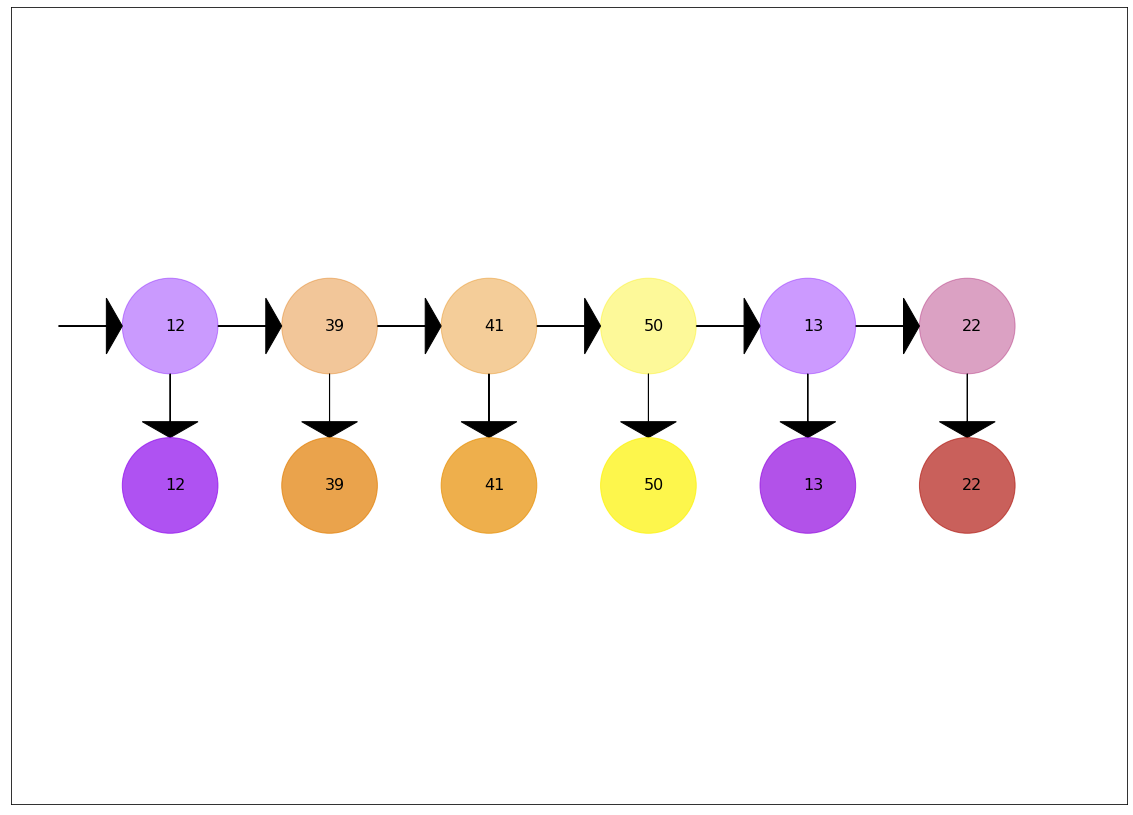

['+--+', '---+', '---0', '-0-0', '+---', '+0--']


In [46]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pclHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing left HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

## Creating human crossing robot path from right HMM

In [47]:
pcr_seqs = pcr_lab_seqs

In [48]:
pcr_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcr_seqs]
print(pcr_seqs)
[list(map(num_to_QTC_C, seq)) for seq in pcr_seqs]

[[37, 64, 47, 37, 47, 64, 37, 47, 10, 46, 37, 47, 10, 47, 37, 47, 37, 46, 37, 47, 37, 47, 10, 64, 37, 47, 10, 37, 10, 37, 38, 47, 10, 37, 10, 38, 47, 10, 37, 38, 74, 10, 37, 10, 74, 37, 65, 47, 10, 37, 74, 11, 74, 10, 11, 20, 74, 53, 11, 38, 11, 20, 11, 20, 9, 11, 74, 20, 9, 38, 9, 11, 47, 20, 9, 38, 20, 9, 36, 11, 20, 12, 9, 36, 9, 20, 9, 39, 9, 20, 74, 12], [37, 47, 64, 37, 47, 37, 46, 47, 37, 47, 37, 47, 37, 47, 10, 37, 47, 10, 37, 47, 37, 47, 37, 38, 47, 37, 47, 10, 64, 47, 37, 47, 10, 37, 47, 10, 37, 64, 37, 47, 10, 64, 10, 65, 10, 64, 11, 47, 10, 11, 65, 74, 11, 14, 11, 74, 11, 65, 20, 9, 11, 65, 9, 11, 9, 11, 20, 9, 20, 9, 11, 9, 74, 20, 47, 20], [64, 37, 64, 37, 47, 10, 37, 46, 47, 37, 47, 37, 47, 10, 37, 47, 10, 37, 47, 37, 47, 37, 47, 10, 64, 20, 47, 10, 65, 47, 37, 10, 37, 47, 64, 10, 11, 37, 10, 38, 11, 65, 74, 10, 11, 74, 47, 74, 11, 65, 11, 20, 11, 38, 9, 11, 65, 11, 20, 9, 11, 9, 11, 20, 74, 20], [37, 47, 37, 47, 10, 37, 47, 37, 47, 37, 46, 47, 37, 47, 10, 37, 47, 37, 47

[['--+-',
  '0-+-',
  '-0+0',
  '--+-',
  '-0+0',
  '0-+-',
  '--+-',
  '-0+0',
  '+-+-',
  '-0+-',
  '--+-',
  '-0+0',
  '+-+-',
  '-0+0',
  '--+-',
  '-0+0',
  '--+-',
  '-0+-',
  '--+-',
  '-0+0',
  '--+-',
  '-0+0',
  '+-+-',
  '0-+-',
  '--+-',
  '-0+0',
  '+-+-',
  '--+-',
  '+-+-',
  '--+-',
  '--+0',
  '-0+0',
  '+-+-',
  '--+-',
  '+-+-',
  '--+0',
  '-0+0',
  '+-+-',
  '--+-',
  '--+0',
  '00+0',
  '+-+-',
  '--+-',
  '+-+-',
  '00+0',
  '--+-',
  '0-+0',
  '-0+0',
  '+-+-',
  '--+-',
  '00+0',
  '+-+0',
  '00+0',
  '+-+-',
  '+-+0',
  '+0+0',
  '00+0',
  '-000',
  '+-+0',
  '--+0',
  '+-+0',
  '+0+0',
  '+-+0',
  '+0+0',
  '+-++',
  '+-+0',
  '00+0',
  '+0+0',
  '+-++',
  '--+0',
  '+-++',
  '+-+0',
  '-0+0',
  '+0+0',
  '+-++',
  '--+0',
  '+0+0',
  '+-++',
  '--++',
  '+-+0',
  '+0+0',
  '+--+',
  '+-++',
  '--++',
  '+-++',
  '+0+0',
  '+-++',
  '---+',
  '+-++',
  '+0+0',
  '00+0',
  '+--+'],
 ['--+-',
  '-0+0',
  '0-+-',
  '--+-',
  '-0+0',
  '--+-',
  '-0+-',
  '-0+0',

In [49]:
# Create transition matrix from handwritten examples of path-crossing QTC_C sequences

# Defining a graph of N_nodes states
# Give low prob. to transitions not present in e.g.s
A = np.ones((N_nodes, N_nodes))
print(A.shape)

# Give frequency based probs to e.g. transitions
for seq in pcr_seqs:
    for i in range(0, len(seq) - 1):
        print(i)
        A[seq[i], seq[i + 1]] += trans_prob_factor

# normalise A (make sure probs sum up to 1)
row_sums = A.sum(axis=1)
A = A / row_sums[:, np.newaxis]

# summing all column of transition matrix
rs = np.sum(A, 1)
print(rs)
print(A)

(81, 81)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
0
1

In [50]:
# creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
# (.1 / N_nodes) for all observations for numerical stability
B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                        prob_emission_equals_hidden)
# B = np.eye(N_nodes)

# normalise B (make sure probs sum up to 1)
row_sums = B.sum(axis=1)
B = B / row_sums[:, np.newaxis]
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))


# Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
Pi = (np.ones((1, N_nodes)))[0]
for seq in pcr_seqs:
    Pi[seq[0]] += init_prob_factor

# normalise Pi (make sure probs sum up to 1)
row_sums = Pi.sum()
Pi = Pi / row_sums

print(Pi)
print(Pi.sum())

# Create HMM using the overtake e.g. parameters
pcrHMM = hmms.DtHMM(A, B, Pi)

# Check otHMM params
A, B, Pi = pcrHMM.params
print("A:\n", A)
A_row_sums = []
for row in A:
    A_row_sums.append(row.sum())
print(np.mean(A_row_sums))
print("B:\n", B)
B_row_sums = []
for row in B:
    B_row_sums.append(row.sum())
print(np.mean(B_row_sums))
print("Pi:\n", Pi)
print(Pi.sum())

1.0
[3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.89808504e-01 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 6.52385589e-02 2.27523531e-01
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.27815644e-02 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 3.24569945e-04 3.24569945e-04 3.24569945e-04 3.24569945e-04
 2.27523531e-01 3.24

In [51]:
A.min()

2.4107422675441778e-05

In [52]:
# draw_transition_matrix(A, "QTC_C_Path_Crossing_Lab_Egs_Transitions", 0.0124)

Path-crossing right HMM:


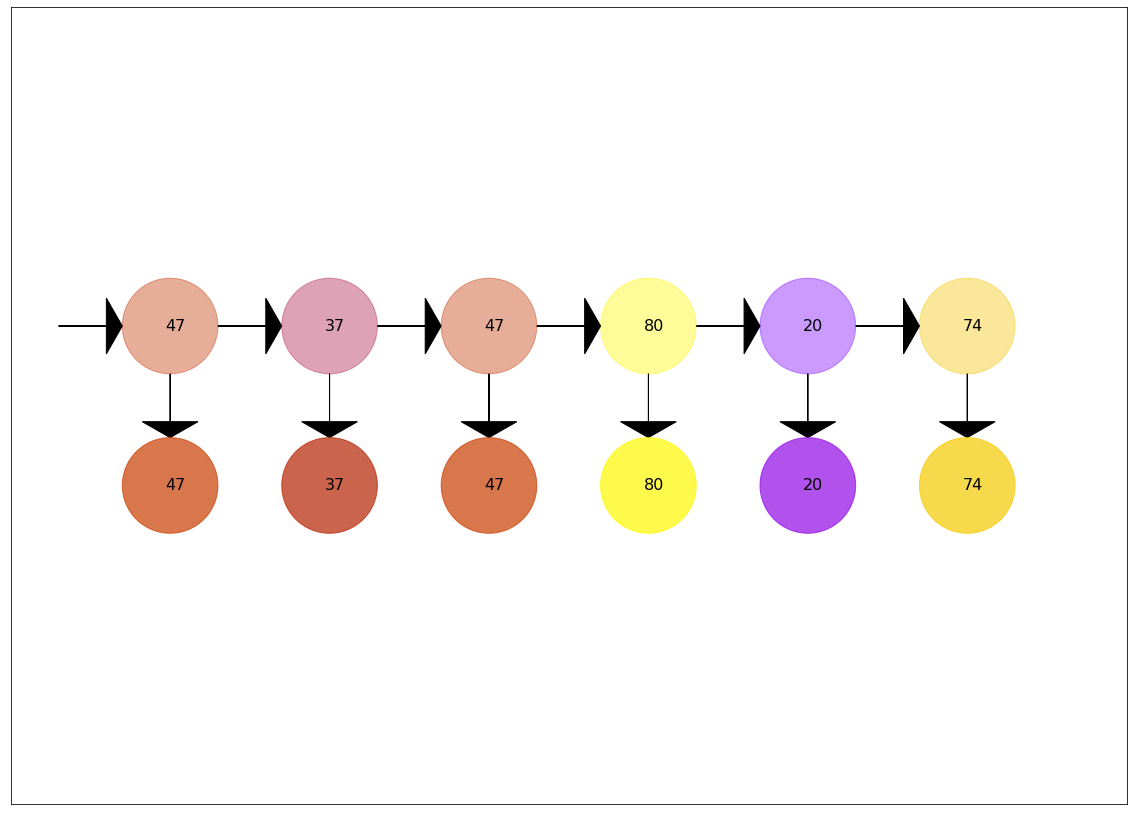

['-0+0', '--+-', '-0+0', '0000', '+0+0', '00+0']


In [53]:
# sample a random sequence from the model (for testing and generation)
# sample uniformly
s_seq, e_seq = pcrHMM.generate(6)

# resize plot
plt.rcParams['figure.figsize'] = [20, 20]

print("Path-crossing right HMM:")
hmms.plot_hmm(s_seq, e_seq)
s_seq_QTC_C_map = map(num_to_QTC_C, s_seq)
print(list(s_seq_QTC_C_map))

In [54]:
def classify_QTC_seqs(e_seqs):
    ll_pb_l = pblHMM.data_estimate(e_seqs)
    # print(ll_pb_l)
    prob_pb_l = np.exp(ll_pb_l)

    # print("The probability of the dataset being generated by the pass-by left model is:", \
    #       prob_pb_l, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs)
    # print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

    # print("The probability of the dataset being generated by the pass-by right model is:", \
    #       prob_pb_r, ".")

    # print("The probability of the dataset being generated by the rejection model is:", \
    #       prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs)
    # print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

    # print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #       prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs)
    # print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

    # print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #       prob_rotr, ".")

    ll_pcl = pclHMM.data_estimate(e_seqs)
    # print(ll_pcl)
    prob_pcl = np.exp(ll_pcl)
    
    ll_pcr = pcrHMM.data_estimate(e_seqs)
    # print(ll_pcr)
    prob_pcr = np.exp(ll_pcr)

    lls = [ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pcl, ll_pcr]
    class_id = np.argmax(lls)
    KL = entropy(lls, [1/len(lls) for ll in lls])
    if KL > rejection_KL_thresh:
        pred = classes[class_id]
    else:
        pred = "rejection"
        class_id = len(classes)
    print("Classified as", pred)
    print("KL divergence of likelihoods from uniform distribution:", KL)
    
    return class_id

## Classifying HRI situation of unmodelled QTC<sub>C</sub> sequences

In [55]:
u_seqs = u_lab_seqs

In [56]:
u_seqs = [list(map(QTC_C_to_num, seq)) for seq in u_seqs]
print(u_seqs)
[list(map(num_to_QTC_C, seq)) for seq in u_seqs]

[[17, 71, 80, 10, 17, 41, 80, 10, 17, 41, 71, 53, 10, 40, 17, 16, 50, 16, 17, 71, 13, 16, 53, 71, 16, 41, 16, 44, 53, 16, 43, 53, 64, 70, 43, 53, 16, 37, 70, 44, 37, 43, 10, 64, 16, 53, 70, 53, 47, 16, 44, 53, 10, 40, 16, 53, 16, 70, 50, 10, 13, 70, 67, 70, 53, 50, 10, 40, 70, 47, 70, 44, 53, 10, 40, 44, 47, 10, 43, 16, 53, 16, 70, 11, 53, 10, 70, 10, 50, 10, 70, 50, 10, 70, 44, 10, 44, 16, 44, 10, 70, 44, 70, 53, 10, 71, 10, 43, 53, 10, 70, 53, 10, 70, 53, 50, 10, 43, 53, 10, 43, 70, 44, 16, 50, 10, 64, 53, 10, 16, 40, 10, 64, 43, 53, 10, 43, 64, 70, 50, 10, 70, 44, 50, 10, 50, 10, 64, 50, 10, 70, 64, 70, 64, 10, 53, 10, 64, 10, 50, 10, 70, 64, 13, 50, 10, 70, 10, 50, 10, 70, 13, 10, 40, 50, 10, 70, 13, 50, 10, 16, 70, 50, 10, 70, 50, 10, 77, 10, 77, 50, 10, 67, 50, 10, 40, 70, 77, 10, 67, 77, 26, 77, 10, 76, 10, 77, 10, 76, 20, 77, 64, 76, 74, 77, 79, 77, 73, 77, 74, 77, 80, 77, 74, 77, 74, 77, 74, 77, 80, 74, 80, 77, 80], [17, 71, 80, 10, 17, 80, 50, 10, 71, 16, 80, 50, 10, 16, 40, 

[['+-00',
  '0-00',
  '0000',
  '+-+-',
  '+-00',
  '---0',
  '0000',
  '+-+-',
  '+-00',
  '---0',
  '0-00',
  '-000',
  '+-+-',
  '----',
  '+-00',
  '+-0-',
  '-0-0',
  '+-0-',
  '+-00',
  '0-00',
  '+---',
  '+-0-',
  '-000',
  '0-00',
  '+-0-',
  '---0',
  '+-0-',
  '--00',
  '-000',
  '+-0-',
  '--0-',
  '-000',
  '0-+-',
  '0-0-',
  '--0-',
  '-000',
  '+-0-',
  '--+-',
  '0-0-',
  '--00',
  '--+-',
  '--0-',
  '+-+-',
  '0-+-',
  '+-0-',
  '-000',
  '0-0-',
  '-000',
  '-0+0',
  '+-0-',
  '--00',
  '-000',
  '+-+-',
  '----',
  '+-0-',
  '-000',
  '+-0-',
  '0-0-',
  '-0-0',
  '+-+-',
  '+---',
  '0-0-',
  '0---',
  '0-0-',
  '-000',
  '-0-0',
  '+-+-',
  '----',
  '0-0-',
  '-0+0',
  '0-0-',
  '--00',
  '-000',
  '+-+-',
  '----',
  '--00',
  '-0+0',
  '+-+-',
  '--0-',
  '+-0-',
  '-000',
  '+-0-',
  '0-0-',
  '+-+0',
  '-000',
  '+-+-',
  '0-0-',
  '+-+-',
  '-0-0',
  '+-+-',
  '0-0-',
  '-0-0',
  '+-+-',
  '0-0-',
  '--00',
  '+-+-',
  '--00',
  '+-0-',
  '--00',
  '+-+-',


In [57]:
u_seqs = [np.array(seq) for seq in u_seqs]

In [58]:
# Generate dataset of both hidden states and emissions sequences from uniform HMM
# symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq] for u_seq in u_seqs]
e_seqs = np.array(u_seqs)

classify_QTC_seqs(e_seqs)

Classified as rejection
KL divergence of likelihoods from uniform distribution: 0.016214968043667337


6

## Classifying HRI situation of example pass-by left QTC<sub>C</sub> sequences

In [59]:
pass_by_l_seqs = [np.array(seq) for seq in pass_by_l_seqs]

In [60]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_l_seqs)

classify_QTC_seqs(e_seqs)

Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.08293927180925603


0

## Classifying HRI situation of example pass-by right QTC<sub>C</sub> sequences

In [61]:
pass_by_r_seqs = [np.array(seq) for seq in pass_by_r_seqs]

In [62]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pass_by_r_seqs)

classify_QTC_seqs(e_seqs)

Classified as PBR
KL divergence of likelihoods from uniform distribution: 0.0710897163809899


1

## Classifying HRI situation of example robot overtaking left QTC<sub>C</sub> sequences

In [63]:
rotl_seqs = [np.array(seq) for seq in rotl_seqs]

In [64]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotl_seqs)

classify_QTC_seqs(e_seqs)

Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.026722517933809982


2

## Classifying HRI situation of example robot overtaking right QTC<sub>C</sub> sequences

In [65]:
rotr_seqs = [np.array(seq) for seq in rotr_seqs]

In [66]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(rotr_seqs)

classify_QTC_seqs(e_seqs)

Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.02971633313568176


3

## Classifying HRI situation of example path-crossing left QTC<sub>C</sub> sequences

In [67]:
pcl_seqs = [np.array(seq) for seq in pcl_seqs]

In [68]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pcl_seqs)

classify_QTC_seqs(e_seqs)

Classified as PCL
KL divergence of likelihoods from uniform distribution: 0.047659898705158944


4

## Classifying HRI situation of example path-crossing right QTC<sub>C</sub> sequences

In [69]:
pcr_seqs = [np.array(seq) for seq in pcr_seqs]

In [70]:
# Get dataset of both hidden states and emissions sequences from example pass-by sequences
e_seqs = np.array(pcr_seqs)

classify_QTC_seqs(e_seqs)

Classified as PCR
KL divergence of likelihoods from uniform distribution: 0.05938837025894943


5

<!-- ## Classifying HRI situation of individual lab QTC<sub>C</sub> sequences -->

In [71]:
# Get hidden states and emissions sequences from observed sequences
# sequence_no = 5

KLs = []
for sequence_no in range(len(u_lab_seqs)):
    symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_lab_seqs[i]] for i in range(len(u_lab_seqs))]
    e_seqs = np.array([symbol_seqs[sequence_no]])
    
    ll_pb_l = pblHMM.data_estimate(e_seqs)
    # print(ll_pb_l)
    prob_pb_l = np.exp(ll_pb_l)

    # print("The probability of the dataset being generated by the pass-by left model is:", \
    #       prob_pb_l, ".")

    ll_pb_r = pbrHMM.data_estimate(e_seqs)
    # print(ll_pb_r)
    prob_pb_r = np.exp(ll_pb_r)

    # print("The probability of the dataset being generated by the pass-by right model is:", \
    #       prob_pb_r, ".")

    # print("The probability of the dataset being generated by the rejection model is:", \
    #       prob_uniform, ".")

    ll_rotl = rotlHMM.data_estimate(e_seqs)
    # print(ll_rotl)
    prob_rotl = np.exp(ll_rotl)

    # print("The probability of the dataset being generated by the robot overtaking left model is:", \
    #       prob_rotl, ".")

    ll_rotr = rotrHMM.data_estimate(e_seqs)
    # print(ll_rotr)
    prob_rotr = np.exp(ll_rotr)

    # print("The probability of the dataset being generated by the robot overtaking right model is:", \
    #       prob_rotr, ".")

    ll_pcl = pclHMM.data_estimate(e_seqs)
    # print(ll_pc)
    prob_pcl = np.exp(ll_pcl)
    
    ll_pcr = pcrHMM.data_estimate(e_seqs)
    # print(ll_pc)
    prob_pcr = np.exp(ll_pcr)

    # print("The probability of the dataset being generated by the path-crossing model is:", \
    #       prob_pc, ".")

    # lls = [ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pc, ll_uniform]
    # classes = ["pass-by left", "pass-by right", "robot overtaking left", "robot overtaking right", "path-crossing", "rejection"]

    lls = [ll_pb_l, ll_pb_r, ll_rotl, ll_rotr, ll_pcl, ll_pcr]
    class_id = np.argmax(lls)
    KL = entropy(lls, [1/len(lls) for ll in lls])
    KLs.append(KL)
    if KL > rejection_KL_thresh:
        pred = classes[class_id]
    else:
        pred = "rejection"
        class_id = len(classes)
    print("Classified as", pred)
#     print("KL divergence of likelihoods from uniform distribution:", KL)

Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection
Classified as rejection


In [72]:
print("KLs:\n")
print("Min:", np.min(KLs))
print("Median", np.median(KLs))
print("Mean", np.mean(KLs))
print("Max:", np.max(KLs))

KLs:

Min: 0.015213812010885123
Median 0.016512907896975612
Mean 0.016474228014445938
Max: 0.017832595862050847


## K-fold CV of Classifying HRSI situation of all expert QTC<sub>C</sub> sequences

In [73]:
rotl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotl_lab_seqs):
    rotl_splits.append([train_index, test_index])
    
rotl_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 15, 17, 18, 19, 22, 24, 26,
         27, 28, 30, 31]),
  array([ 0,  1,  9, 12, 14, 16, 20, 21, 23, 25, 29])],
 [array([ 0,  1,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 20, 21, 22, 23, 25,
         26, 28, 29, 31]),
  array([ 2,  3,  4,  5,  6, 10, 17, 19, 24, 27, 30])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 14, 16, 17, 19, 20, 21, 23,
         24, 25, 27, 29, 30]),
  array([ 7,  8, 11, 13, 15, 18, 22, 26, 28, 31])]]

In [74]:
rotr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(rotr_lab_seqs):
    rotr_splits.append([train_index, test_index])
    
rotr_splits

[[array([ 2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 15, 17, 18, 21, 22, 23, 25,
         27, 29, 30]), array([ 0,  1,  9, 12, 14, 16, 19, 20, 24, 26, 28])],
 [array([ 0,  1,  7,  8,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25,
         26, 27, 28, 30]), array([ 2,  3,  4,  5,  6, 10, 17, 21, 23, 29])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 14, 16, 17, 19, 20, 21, 23,
         24, 26, 28, 29]), array([ 7,  8, 11, 13, 15, 18, 22, 25, 27, 30])]]

In [75]:
pbl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_l_lab_seqs):
    pbl_splits.append([train_index, test_index])
    
pbl_splits

[[array([ 2,  4,  5,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 22, 24, 25, 26,
         27, 28, 29]), array([ 0,  1,  3,  6,  9, 14, 19, 20, 21, 23])],
 [array([ 0,  1,  3,  6,  7,  8,  9, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23,
         24, 26, 29]), array([ 2,  4,  5, 10, 12, 16, 17, 25, 27, 28])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 14, 16, 17, 19, 20, 21, 23,
         25, 27, 28]), array([ 7,  8, 11, 13, 15, 18, 22, 24, 26, 29])]]

In [76]:
pbr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pb_r_lab_seqs):
    pbr_splits.append([train_index, test_index])
    
pbr_splits

[[array([ 2,  4,  5,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 22, 24, 25, 26,
         27, 28, 29]), array([ 0,  1,  3,  6,  9, 14, 19, 20, 21, 23])],
 [array([ 0,  1,  3,  6,  7,  8,  9, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23,
         24, 26, 29]), array([ 2,  4,  5, 10, 12, 16, 17, 25, 27, 28])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 14, 16, 17, 19, 20, 21, 23,
         25, 27, 28]), array([ 7,  8, 11, 13, 15, 18, 22, 24, 26, 29])]]

In [77]:
pcl_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pcl_lab_seqs):
    pcl_splits.append([train_index, test_index])
    
pcl_splits

[[array([ 2,  4,  5,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 22, 24, 25, 26,
         27, 28, 29]), array([ 0,  1,  3,  6,  9, 14, 19, 20, 21, 23])],
 [array([ 0,  1,  3,  6,  7,  8,  9, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23,
         24, 26, 29]), array([ 2,  4,  5, 10, 12, 16, 17, 25, 27, 28])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 14, 16, 17, 19, 20, 21, 23,
         25, 27, 28]), array([ 7,  8, 11, 13, 15, 18, 22, 24, 26, 29])]]

In [78]:
pcr_splits = []
for train_index, test_index in KFold(n_splits=K, random_state=random_state, shuffle=True).split(pcr_lab_seqs):
    pcr_splits.append([train_index, test_index])
    
pcr_splits

[[array([ 2,  4,  5,  7,  8, 10, 11, 12, 13, 15, 16, 17, 18, 22, 24, 25, 26,
         27, 28, 29]), array([ 0,  1,  3,  6,  9, 14, 19, 20, 21, 23])],
 [array([ 0,  1,  3,  6,  7,  8,  9, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23,
         24, 26, 29]), array([ 2,  4,  5, 10, 12, 16, 17, 25, 27, 28])],
 [array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 12, 14, 16, 17, 19, 20, 21, 23,
         25, 27, 28]), array([ 7,  8, 11, 13, 15, 18, 22, 24, 26, 29])]]

In [79]:
overall_accs = []
rotl_accs = []
rotr_accs = []
pbl_accs = []
pbr_accs = []
pcl_accs = []
pcr_accs = []
u_accs = []
y_true = []
y_pred = []

for k in range(K):    
    rotl_lab_seqs_train = np.array(rotl_lab_seqs)[rotl_splits[k][0]]
    rotl_lab_seqs_val = np.array(rotl_lab_seqs)[rotl_splits[k][1]]
    
    rotr_lab_seqs_train = np.array(rotr_lab_seqs)[rotr_splits[k][0]]
    rotr_lab_seqs_val = np.array(rotr_lab_seqs)[rotr_splits[k][1]]
    
    pb_l_lab_seqs_train = np.array(pb_l_lab_seqs)[pbl_splits[k][0]]
    pb_l_lab_seqs_val = np.array(pb_l_lab_seqs)[pbl_splits[k][1]]
    
    pb_r_lab_seqs_train = np.array(pb_r_lab_seqs)[pbr_splits[k][0]]
    pb_r_lab_seqs_val = np.array(pb_r_lab_seqs)[pbr_splits[k][1]]
    
    pcl_lab_seqs_train = np.array(pcl_lab_seqs)[pcl_splits[k][0]]
    pcl_lab_seqs_val = np.array(pcl_lab_seqs)[pcl_splits[k][1]]
    
    pcr_lab_seqs_train = np.array(pcr_lab_seqs)[pcr_splits[k][0]]
    pcr_lab_seqs_val = np.array(pcr_lab_seqs)[pcr_splits[k][1]]

    
    u_lab_seqs_val = u_lab_seqs
    
        
    ## Re-build models from training data
    ## Creating pass-by left HMM

    pass_by_l_seqs = pb_l_lab_seqs_train

    pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]
#     print(pass_by_l_seqs)
#     [list(map(num_to_QTC_C, seq)) for seq in pass_by_l_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_l_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_l_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pblHMM = hmms.DtHMM(A, B, Pi)

    # Check pblHMM params
    A, B, Pi = pblHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

#     pass_by_l_seqs = tuple(pass_by_l_seqs)
    pass_by_l_seqs = [np.asarray(seq) for seq in pass_by_l_seqs]
    pass_by_l_seqs = np.asarray(pass_by_l_seqs)
#     print(pass_by_l_seqs)
#     pass_by_l_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_l_seqs]

    ## Creating pass-by right HMM

    pass_by_r_seqs = pb_r_lab_seqs_train

    pass_by_r_seqs = [list(map(QTC_C_to_num, seq)) for seq in pass_by_r_seqs]
#     print(pass_by_r_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pass_by_r_seqs]

    # Create transition matrix from handwritten examples of pass-by QTC-B sequences
    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pass_by_r_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())

    # Pi is the vector of initial state probabilities. Using distribution present in pass-by e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pass_by_r_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

    # print(Pi)
    # print(Pi.sum())

    # Create HMM using the pass-by e.g. parameters
    pbrHMM = hmms.DtHMM(A, B, Pi)

    # Check pbrHMM params
    A, B, Pi = pbrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes left HMM

    rotl_seqs = rotl_lab_seqs_train

    rotl_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotl_seqs]
#     print(rotl_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotl_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotl_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotl_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotlHMM = hmms.DtHMM(A, B, Pi)

    # Check rotlHMM params
    A, B, Pi = rotlHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating robot overtakes right HMM

    rotr_seqs = rotr_lab_seqs_train

    rotr_seqs = [list(map(QTC_C_to_num, seq)) for seq in rotr_seqs]
#     print(rotr_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in rotr_seqs]

    # Create transition matrix from handwritten examples of overtake QTC-B sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in rotr_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in overtake e.g.s
    # (We may make a stronger assumption here at some point)
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in rotr_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the overtake e.g. parameters
    rotrHMM = hmms.DtHMM(A, B, Pi)

    # Check rotrHMM params
    A, B, Pi = rotrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())

    ## Creating path-crossing left HMM

    pcl_seqs = pcl_lab_seqs_train

    pcl_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcl_seqs]
#     print(pc_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pcl_seqs]

    # Create transition matrix from handwritten examples of path-crossing QTC_C sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pcl_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pcl_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the path-crossing e.g. parameters
    pclHMM = hmms.DtHMM(A, B, Pi)

    # Check pcHMM params
    A, B, Pi = pclHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())


    ## Creating path-crossing right HMM

    pcr_seqs = pcr_lab_seqs_train

    pcr_seqs = [list(map(QTC_C_to_num, seq)) for seq in pcr_seqs]
#     print(pc_seqs)
    [list(map(num_to_QTC_C, seq)) for seq in pcr_seqs]

    # Create transition matrix from handwritten examples of path-crossing QTC_C sequences

    # Defining a graph of N_nodes states
    # Give low prob. to transitions not present in e.g.s
    A = np.ones((N_nodes, N_nodes))
#     print(A.shape)

    # Give frequency based probs to e.g. transitions
    for seq in pcr_seqs:
        for i in range(0, len(seq) - 1):
#             print(i)
            A[seq[i], seq[i + 1]] += trans_prob_factor

    # normalise A (make sure probs sum up to 1)
    row_sums = A.sum(axis=1)
    A = A / row_sums[:, np.newaxis]

    # summing all column of transition matrix
    rs = np.sum(A, 1)
#     print(rs)
#     print(A)

    # creating observation matrix, assuming each states has ~90% prob to emit the state itself as observation
    # (.1 / N_nodes) for all observations for numerical stability
    B = (np.ones(N_nodes) * (prob_emission_not_equals_hidden / N_nodes)) + (np.eye(N_nodes) * 
                                                                            prob_emission_equals_hidden)
    # B = np.eye(N_nodes)

    # normalise B (make sure probs sum up to 1)
    row_sums = B.sum(axis=1)
    B = B / row_sums[:, np.newaxis]
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))


    # Pi is the vector of initial state probabilities. Using distribution present in path-crossing e.g.s
    Pi = (np.ones((1, N_nodes)))[0]
    for seq in pcr_seqs:
        Pi[seq[0]] += init_prob_factor

    # normalise Pi (make sure probs sum up to 1)
    row_sums = Pi.sum()
    Pi = Pi / row_sums

#     print(Pi)
#     print(Pi.sum())

    # Create HMM using the path-crossing e.g. parameters
    pcrHMM = hmms.DtHMM(A, B, Pi)

    # Check pcHMM params
    A, B, Pi = pcrHMM.params
#     print("A:\n", A)
    A_row_sums = []
    for row in A:
        A_row_sums.append(row.sum())
#     print(np.mean(A_row_sums))
#     print("B:\n", B)
    B_row_sums = []
    for row in B:
        B_row_sums.append(row.sum())
#     print(np.mean(B_row_sums))
#     print("Pi:\n", Pi)
#     print(Pi.sum())
            
    
    # Get correct count and accuracy of pass-by left classifications
    pb_l_correct = 0
    for pb_l_seq in pb_l_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_l_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 0
        y_true.append(correct_class_id)
        y_pred.append(class_id)
        
        if class_id == correct_class_id:
            pb_l_correct += 1
            
        pb_l_acc = pb_l_correct/len(pb_l_lab_seqs_val)*100
#     print("Pass-by left classifications are " + str(pb_l_acc) + "% accurate" )

    # Get correct count and accuracy of pass-by right classifications
    pb_r_correct = 0
    for pb_r_seq in pb_r_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pb_r_seq]]
        e_seqs = np.array(symbol_seqs)
        
        class_id = classify_QTC_seqs(e_seqs)
        
        correct_class_id = 1
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pb_r_correct += 1
            
        pb_r_acc = (pb_r_correct/len(pb_r_lab_seqs_val))*100
#     print("Pass-by right classifications are " + str(pb_r_acc) + "% accurate" )

    # Get correct count and accuracy of robot overtaking left classifications
    rotl_correct = 0
    for rotl_seq in rotl_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotl_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 2
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            rotl_correct += 1
            
        rotl_acc = (rotl_correct/len(rotl_lab_seqs_val))*100
#     print("Robot overtaking left classifications are " + str(rotl_acc) + "% accurate" )

    # Get correct count and accuracy of robot overtaking right classifications
    rotr_correct = 0
    for rotr_seq in rotr_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in rotr_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 3
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            rotr_correct += 1
            
        rotr_acc = (rotr_correct/len(rotr_lab_seqs_val))*100
#     print("Robot overtaking right classifications are " + str(rotr_acc) + "% accurate" )

    # Get correct count and accuracy of path-crossing left classifications
    pcls_correct = 0
    for pcl_seq in pcl_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pcl_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 4
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pcls_correct += 1
            
        pcl_acc = (pcls_correct/len(pcl_lab_seqs_val))*100
#     print("Path-crossing left classifications are " + str(pcl_acc) + "% accurate" )


# Get correct count and accuracy of path-crossing right classifications
    pcrs_correct = 0
    for pcr_seq in pcr_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in pcr_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = 5
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            pcrs_correct += 1
            
        pcr_acc = (pcrs_correct/len(pcr_lab_seqs_val))*100
#     print("Path-crossing classifications are " + str(pc_acc) + "% accurate" )

    # Get correct count and accuracy of rejections
    us_correct = 0
    for u_seq in u_lab_seqs_val:
        symbol_seqs = [[QTC_C_to_num(qtc) for qtc in u_seq]]
        e_seqs = np.array(symbol_seqs)

        class_id = classify_QTC_seqs(e_seqs)

        correct_class_id = len(classes)
        y_true.append(correct_class_id)
        y_pred.append(class_id)
    
        if class_id == correct_class_id:
            us_correct += 1

    # Rejections recall
    rTPs = us_correct
    rFNs = len(u_lab_seqs_val) - us_correct
    # rFPs = 0 # As accuracy in all other classes is 100%
    recall = rTPs / (rTPs + rFNs)
    # precision = rTPs / (rTPs + rFPs)
    
    u_acc = us_correct/len(u_lab_seqs_val)*100

#     print("Rejections FN rate: " + str((rFNs/len(u_lab_seqs_val)*100)) + "%")
#     print("Rejections accuracy: " + str(u_acc) + "%" )
#     print("Rejection recall:", str(recall * 100) + "%")
    # print("Rejection precision:", str(precision * 100) + "%")

    total = len(pb_l_lab_seqs_val) + len(pb_r_lab_seqs_val) + len(rotl_lab_seqs_val) + len(rotl_lab_seqs_val) + len(pcl_lab_seqs_val) + len(pcr_lab_seqs_val)
    total_correct = pb_l_correct + pb_r_correct + rotr_correct + rotl_correct + pcls_correct + pcrs_correct

    overall_acc = (total_correct/total)*100
    print("k", k+1, "/", K)
    print("\nOverall accuracy (excluding rejections): " + str(overall_acc) + "%")
    print("Robot overtaking left TPR: " + str(np.mean(rotl_acc)) + "%")
    print("Robot overtaking right TPR: " + str(np.mean(rotr_acc)) + "%")
    print("Pass-by left TPR: " + str(np.mean(pb_l_acc)) + "%")
    print("Pass-by right TPR: " + str(np.mean(pb_r_acc)) + "%")
    print("Path-crossing left TPR: " + str(np.mean(pcl_acc)) + "%")
    print("Path-crossing right TPR: " + str(np.mean(pcr_acc)) + "%")
    print("Rejection TPR: " + str(np.mean(u_acc)) + "%\n")
    
    overall_accs.append(overall_acc)
    rotl_accs.append(rotl_acc)
    rotr_accs.append(rotr_acc)
    pbl_accs.append(pb_l_acc)
    pbr_accs.append(pb_r_acc)
    pcl_accs.append(pcl_acc)
    pcr_accs.append(pcr_acc)
    u_accs.append(u_acc)
    
    if k == 2:
        pblHMM.save_params("pblHMM_k_3_study")
        pbrHMM.save_params("pbrHMM_k_3_study")
        rotlHMM.save_params("rotlHMM_k_3_study")
        rotrHMM.save_params("rotrHMM_k_3_study")
        pclHMM.save_params("pclHMM_k_3_study")
        pcrHMM.save_params("pcrHMM_k_3_study")

Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.070758690591648
Classified as rejection
KL divergence of likelihoods from uniform distribution: 0.00411417815131452
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.06596319837560757
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.07270686103313113
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.09403470477472833
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.05900914977597875
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.04780920518208798
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.06248872908091742
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.10482661053691114
Classified as PBL
KL divergence of likelihoods from uniform distribution: 0.07453980661981002
Classified as PBL
KL divergence of likelihoods from unif

Classified as PBR
KL divergence of likelihoods from uniform distribution: 0.05149518352646885
Classified as PBR
KL divergence of likelihoods from uniform distribution: 0.05426537466118962
Classified as PBR
KL divergence of likelihoods from uniform distribution: 0.04586876761131925
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.02751404453165447
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.025615048612644353
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.028854960622298746
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.0272250462381143
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.028143798165465493
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.02498675762125153
Classified as ROTL
KL divergence of likelihoods from uniform distribution: 0.02424139324462747
Classified as ROTL
KL divergence of likelihoods fro

Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.028618950501393705
Classified as rejection
KL divergence of likelihoods from uniform distribution: 0.010620176133896006
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.03062534449383952
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.030410887207478914
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.02319353333982352
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.02335140219310307
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.02787694618078409
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.025254942793024402
Classified as ROTR
KL divergence of likelihoods from uniform distribution: 0.028512019386406694
Classified as PCL
KL divergence of likelihoods from uniform distribution: 0.04205413880850871
Classified as PCL
KL divergence of likeli

In [80]:
print("K-fold CV results:")
print("Overall accuracy: " + str(np.mean(overall_accs)) + "%")
print("Robot overtaking left TPR: " + str(np.mean(rotl_accs)) + "%")
print("Robot overtaking right TPR: " + str(np.mean(rotr_accs)) + "%")
print("Pass-by left TPR: " + str(np.mean(pbl_accs)) + "%")
print("Pass-by right TPR: " + str(np.mean(pbr_accs)) + "%")
print("Path-crossing left TPR: " + str(np.mean(pcl_accs)) + "%")
print("Path-crossing right TPR: " + str(np.mean(pcr_accs)) + "%")
print("Rejection TPR: " + str(np.mean(u_accs)) + "%")

K-fold CV results:
Overall accuracy: 88.01075268817203%
Robot overtaking left TPR: 93.63636363636363%
Robot overtaking right TPR: 90.3030303030303%
Pass-by left TPR: 76.66666666666667%
Pass-by right TPR: 70.0%
Path-crossing left TPR: 100.0%
Path-crossing right TPR: 100.0%
Rejection TPR: 100.0%


In [81]:
len(classes)

6

In [82]:
cm = confusion_matrix(y_true, y_pred)
cm

/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:167: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:168: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:170: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/loz/QTC_Trajectory_HMMs/from_bags/confusion_matrix_pretty_print.py:171: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = Fa

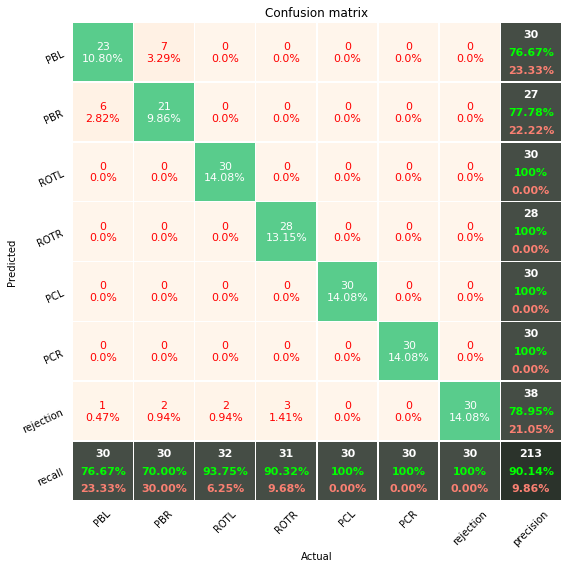

In [83]:
df_cm = pd.DataFrame(cm, range(len(classes)+1), range(len(classes)+1))
classes.append("rejection")
df_cm.columns = classes
df_cm.index = classes
df_cm

# From MATLAB plotconfusion docs (which inspired this confusion matrix plotting module):
# The column on the far right of the plot shows the percentages of all the examples predicted to belong to each
# class that are correctly and incorrectly classified. These metrics are often called the precision 
# (or positive predictive value) and false discovery rate, respectively. The row at the bottom of the plot shows
# the percentages of all the examples belonging to each class that are correctly and incorrectly classified. 
# These metrics are often called the recall (or true positive rate) and false negative rate, respectively.
# The cell in the bottom right of the plot shows the overall accuracy.
pretty_plot_confusion_matrix(df_cm, show_null_values=2)